In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import Holt
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

In [2]:
# The dataset contains the minimum temperatures over 10 years (1981-1990) in the city Melbourne, Australia
train=pd.read_csv("/content/drive/My Drive/Time Series /train_temperature_time_series.csv")
test=pd.read_csv("/content/drive/My Drive/Time Series /test_temperature_time_series.csv")

In [3]:
train_original=train.copy()
test_original=test.copy()

In [4]:
train.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [5]:
train.dtypes, test.dtypes

(Date     object
 Temp    float64
 dtype: object, Date     object
 Temp    float64
 dtype: object)

In [6]:
train.shape, test.shape

((3285, 2), (365, 2))

In [7]:
train['Date']=pd.to_datetime(train.Date,format= '%Y-%m-%d')
test['Date']=pd.to_datetime(test.Date,format= '%Y-%m-%d')
train_original['Date']=pd.to_datetime(train_original.Date,format= '%Y-%m-%d')
test_original['Date']=pd.to_datetime(test_original.Date,format= '%Y-%m-%d')



In [8]:
for i in (train,test,train_original,test_original):
  i['year']=i.Date.dt.year
  i['month']=i.Date.dt.month
  i['day']=i.Date.dt.day

In [9]:
train.set_index('Date',inplace=True)

 Visualization and Exploratory Data Analysis

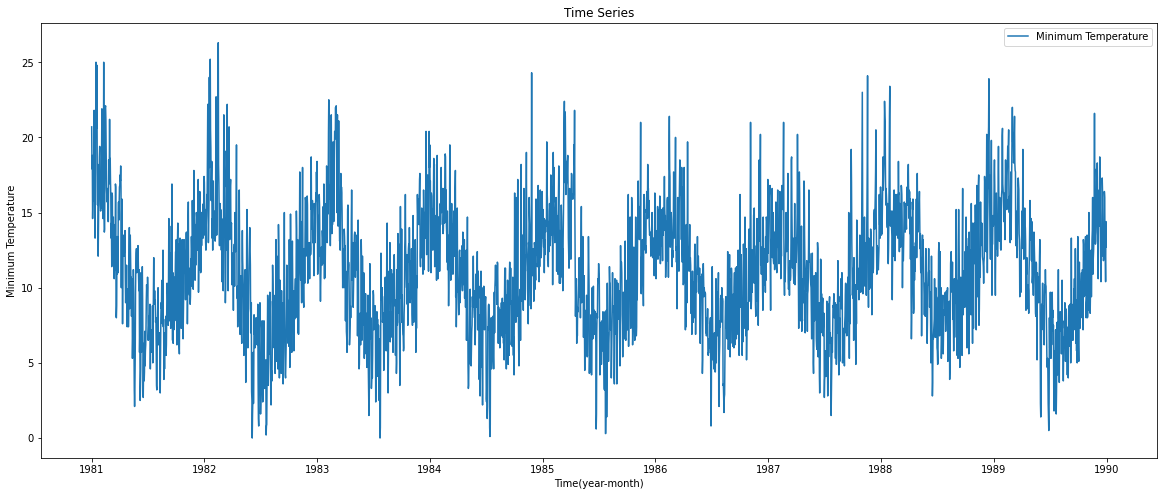

In [10]:
# Plotting data
df=train
ts=df['Temp']
plt.figure(figsize=(20,8))
plt.plot(ts,label='Minimum Temperature')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Minimum Temperature')
plt.legend(loc='best')

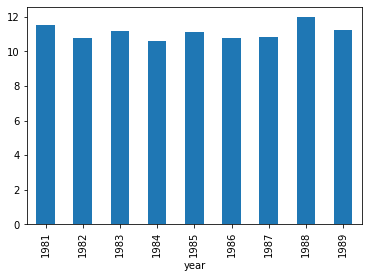

In [11]:
#Yearly mean of minimum Temperatures
train.groupby('year')['Temp'].mean().plot.bar()

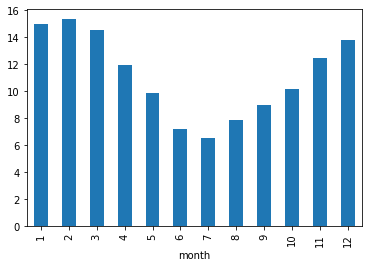

In [12]:
# Monthly mean of minimum Temperature
train.groupby('month')['Temp'].mean().plot.bar()

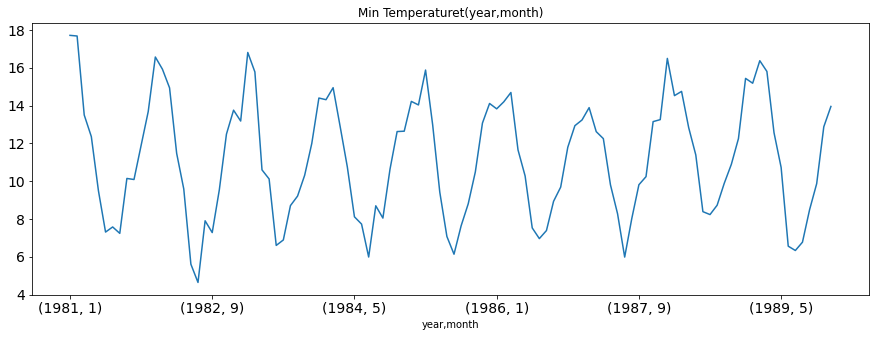

In [13]:
# Trend including month and year data
tem=train.groupby(['year','month'])['Temp'].mean()
tem.plot(figsize=(15,5),title='Min Temperaturet(year,month)',fontsize=14)
#Thus we understand that it is seasonal trend

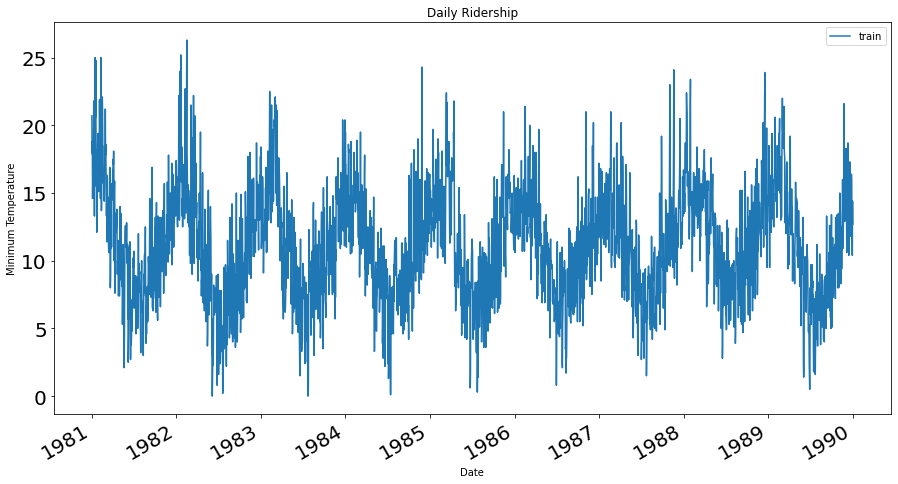

In [37]:
train.Temp.plot(figsize=(15,8),title='Daily Ridership',fontsize=20,label='train')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature')
plt.legend(loc='best')
plt.show()

In [32]:
#To make graph smooth we will use monthly predictions
monthly_train=train.resample('M').mean()

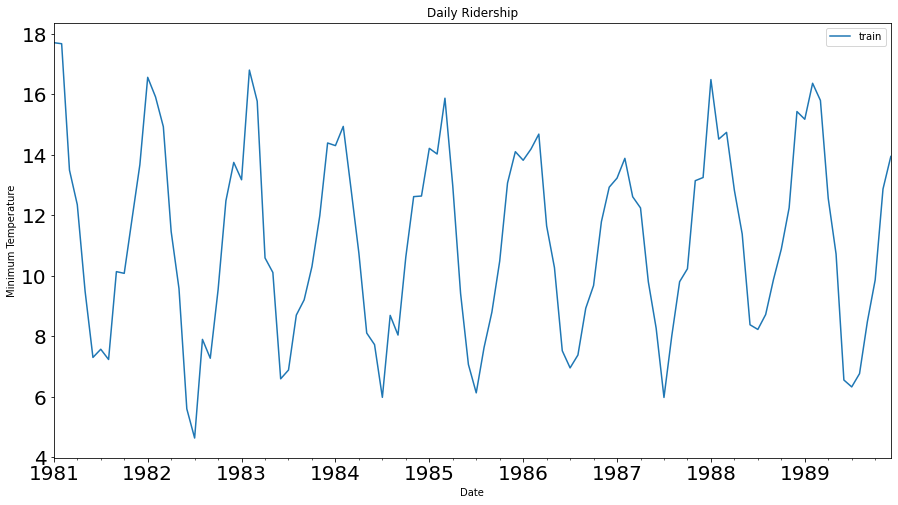

In [38]:
monthly_train.Temp.plot(figsize=(15,8),title='Daily Ridership',fontsize=20,label='train')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature')
plt.legend(loc='best')
plt.show()

Check if Data is Stationary 

---



In [39]:
#Perform Dickey-Fuller test:
#If p-value is less than 0.05 data is stationary


def test_stationarity(timeseries):
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)

test_stationarity(monthly_train['Temp'])

#p-value is 0.32 therefore it is not stationary

Results of Dickey-Fuller Test:
Test Statistic                 -1.919769
p-value                         0.322819
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [40]:
#Make the Data Stationary
#Differencing

monthly_train['Monthly Difference'] = monthly_train['Temp'] - monthly_train['Temp'].shift(12)

In [42]:
monthly_train.head(20)

,Temp,year,month,day,Monthly Difference
Date,,,,,
1981-01-31,17.712903,1981.0,1.0,16.0,NaN
1981-02-28,17.678571,1981.0,2.0,14.5,NaN
1981-03-31,13.500000,1981.0,3.0,16.0,NaN
1981-04-30,12.356667,1981.0,4.0,15.5,NaN
1981-05-31,9.490323,1981.0,5.0,16.0,NaN
1981-06-30,7.306667,1981.0,6.0,15.5,NaN
1981-07-31,7.577419,1981.0,7.0,16.0,NaN
1981-08-31,7.238710,1981.0,8.0,16.0,NaN
1981-09-30,10.143333,1981.0,9.0,15.5,NaN


In [44]:
#Again dicky-fuller test

test_stationarity(monthly_train['Monthly Difference'].dropna())

#Now data is stationary

Results of Dickey-Fuller Test:
Test Statistic                 -3.972509
p-value                         0.001562
#Lags Used                     11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


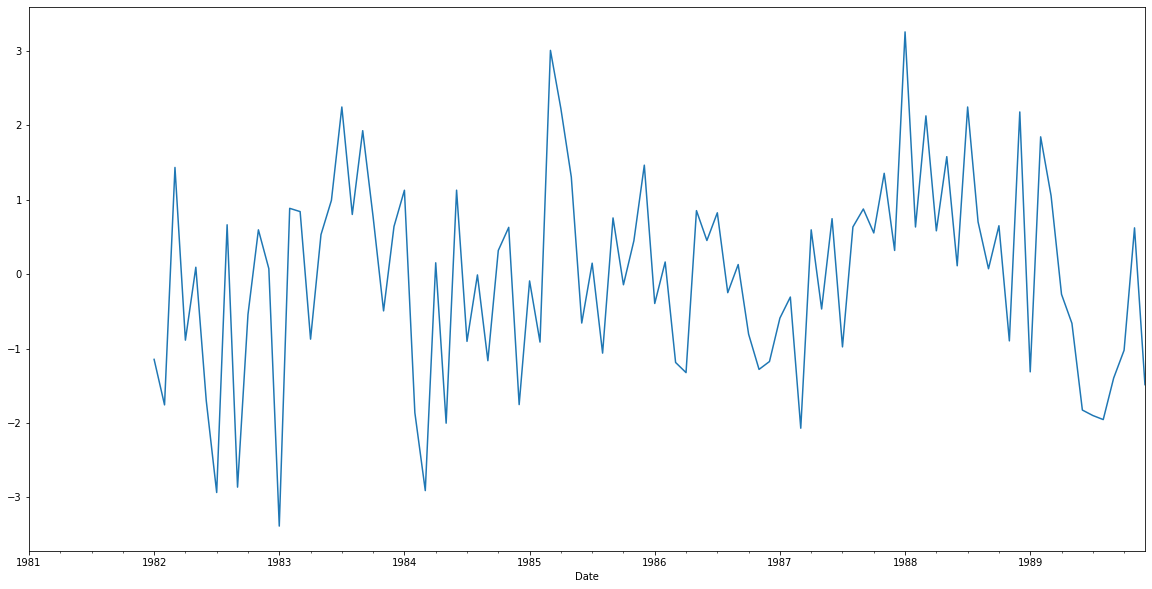

In [45]:
monthly_train['Monthly Difference'].plot()

In [47]:
monthly_train.shape

(108, 5)

AutoCorrelation and Partial AutoCorrelation Plots

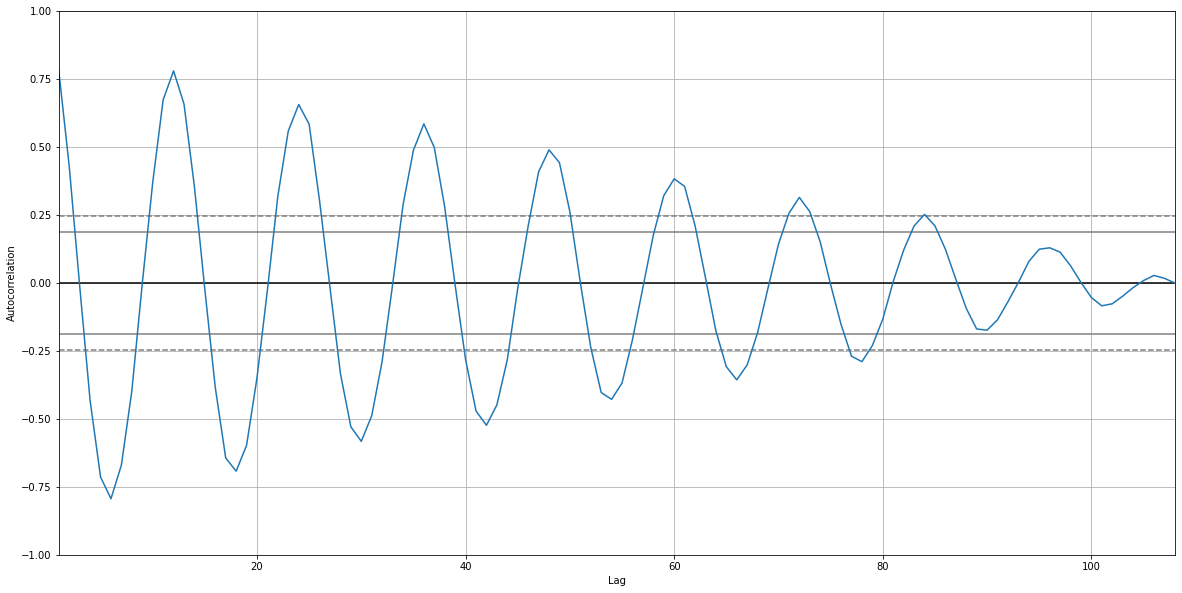

In [48]:
autocorrelation_plot(monthly_train['Temp'])
plt.show()

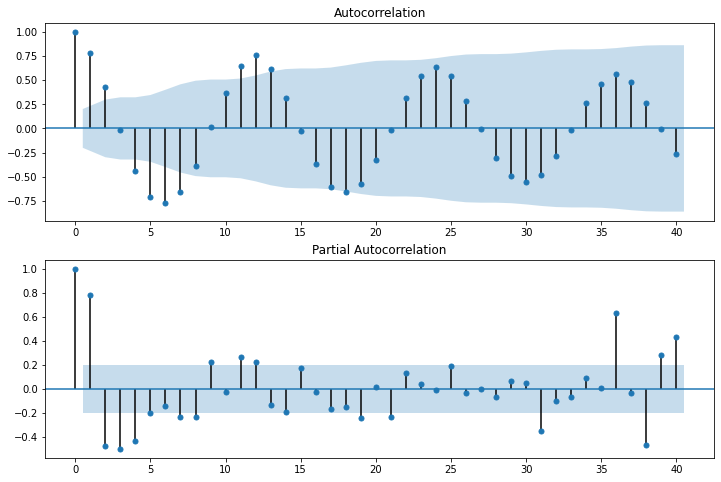

In [49]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_train['Temp'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_train['Temp'].iloc[13:],lags=40,ax=ax2)


# p AR lags look pacf
# d differencing
# q MA Lags look acf

In [61]:
#p=1, d=1, q=2 or 1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Seasonal Autoregressive Integrated Moving Average

In [ ]:
#Applying SARIMA
model=sm.tsa.statespace.SARIMAX(monthly_train['Temp'],order=(1, 1, 2),seasonal_order=(1,1,2,12))
results=model.fit()

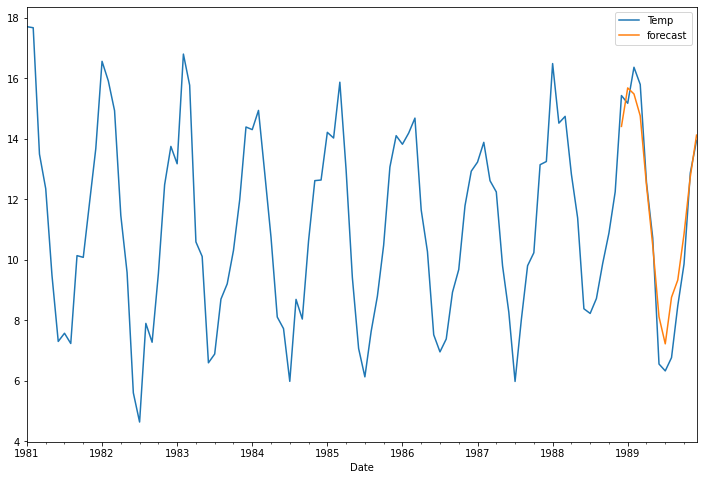

In [62]:
monthly_train['forecast']=results.predict(start=95,end=108,dynamic=True)
monthly_train[['Temp','forecast']].plot(figsize=(12,8))

In [ ]:
# Test on next year Minimal Temperature
test.set_index('Date',inplace=True)

In [83]:
monthly_test=test.resample('M').mean()

In [92]:
future_temp=pd.concat([monthly_train,monthly_test])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2292: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


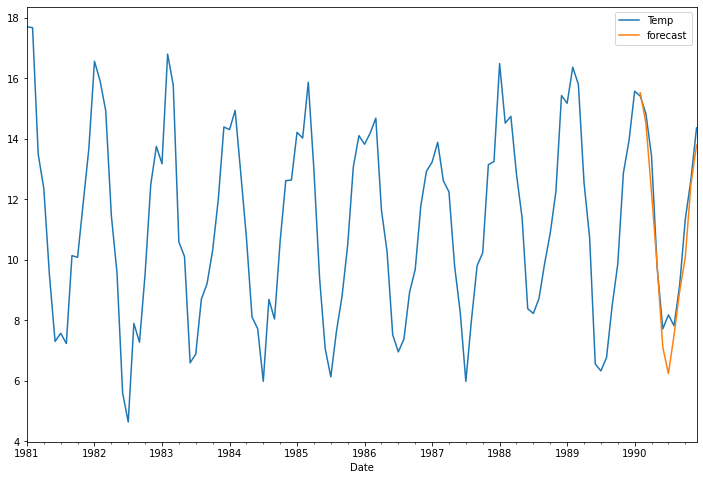

In [94]:
future_temp['forecast'] = results.predict(start = 109, end = 120, dynamic= True)  
future_temp[['Temp', 'forecast']].plot(figsize=(12, 8))